## 4. Model Retraining
If drift, retrain on batches 1-4, compare F1/AUC deltas.

In [4]:

import os
import sys
project_root = r'c:\Users\anuda\Desktop\cell2cell_churn_drift'
os.chdir(project_root)
sys.path.insert(0, project_root)
import pandas as pd
import joblib
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, roc_auc_score
from xgboost import XGBClassifier
from src.config import NUMERIC_FEATURES, CATEGORICAL_FEATURES, TARGET, MODEL_PARAMS

# Assume has_drift from 03 (or re-run detect_drift)
has_drift = True  # for test
print(f"Drift Status: {has_drift}")

Drift Status: True


INFO:src.model.train:Baseline training on 8167 samples, churn rate: 12.62%


Baseline scale_pos_weight: 2.0


d:\anconda\envs\foml\Lib\site-packages\xgboost\callback.py:386: UserWarning: [22:28:32] WARNING: D:\bld\xgboost-split_1767713749021\work\src\learner.cc:790: 
Parameters: { "verbose" } are not used.

  self.starting_round = model.num_boosted_rounds()


Probs mean: 0.2098125


INFO:src.model.train:Baseline Best params: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}


Baseline Best threshold: 0.3599999999999999
Baseline Best F1: 0.4230171073094868

Baseline Classification Report (Optimized Threshold):

              precision    recall  f1-score   support

           0       0.93      0.86      0.89      1784
           1       0.35      0.53      0.42       258

    accuracy                           0.82      2042
   macro avg       0.64      0.69      0.66      2042
weighted avg       0.85      0.82      0.83      2042

Baseline AUC: 0.7944802203914207
Baseline F1: 0.423, AUC: 0.794


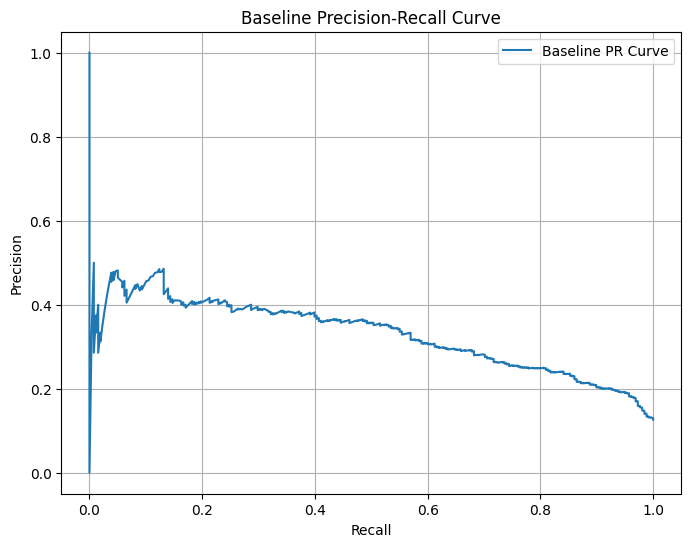

INFO:src.model.train:Baseline Model & dist saved.
INFO:src.model.train:Retrained training on 32670 samples, churn rate: 21.85%


Retrained scale_pos_weight: 2.0


d:\anconda\envs\foml\Lib\site-packages\xgboost\callback.py:386: UserWarning: [22:28:41] WARNING: D:\bld\xgboost-split_1767713749021\work\src\learner.cc:790: 
Parameters: { "verbose" } are not used.

  self.starting_round = model.num_boosted_rounds()


Probs mean: 0.3258775


INFO:src.model.train:Retrained Best params: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100}


Retrained Best threshold: 0.4199999999999998
Retrained Best F1: 0.5352171202991897

Retrained Classification Report (Optimized Threshold):

              precision    recall  f1-score   support

           0       0.90      0.73      0.81      6384
           1       0.43      0.72      0.54      1784

    accuracy                           0.73      8168
   macro avg       0.66      0.72      0.67      8168
weighted avg       0.80      0.73      0.75      8168

Retrained AUC: 0.7871352551080617
Retrained F1: 0.535, AUC: 0.787


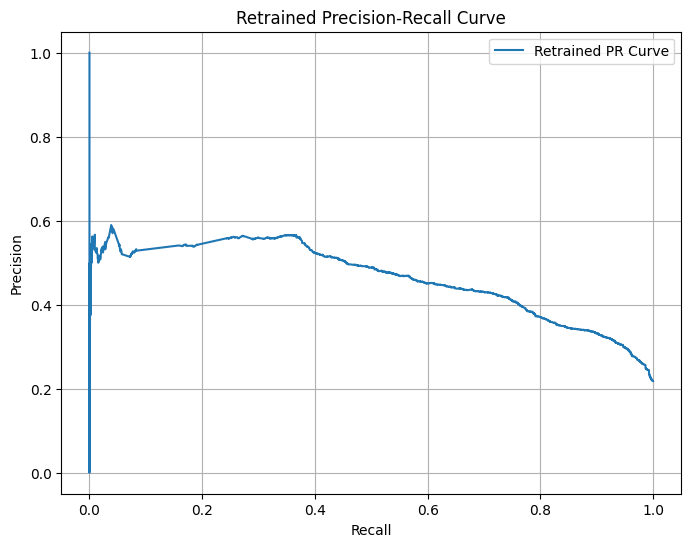

INFO:src.model.train:Retrained Model & dist saved.


Delta F1: +0.112 (Baseline 0.423 → Retrained 0.535)
Delta AUC: -0.007 (Baseline 0.794 → Retrained 0.787)
Retrain complete — adapted to drift!


In [5]:
from src.model.train import train_model
import pandas as pd
import joblib

if has_drift:
    # Baseline ref (on batch_0)
    baseline_results = train_model('data/batches/batch_0.csv', 'baseline')
    f1_base = baseline_results['f1']
    auc_base = baseline_results['auc']
    
    # Concat recent for retrain
    recent_data = pd.concat([pd.read_csv(f"data/batches/batch_{i}.csv") for i in range(1, 5)], ignore_index=True)
    recent_path = 'data/batches/recent_concat.csv'
    recent_data.to_csv(recent_path, index=False)
    
    # Retrain
    retrain_results = train_model(recent_path, 'retrained')
    f1_re = retrain_results['f1']
    auc_re = retrain_results['auc']
    
    # Deltas
    print(f"Delta F1: {f1_re - f1_base:+.3f} (Baseline {f1_base:.3f} → Retrained {f1_re:.3f})")
    print(f"Delta AUC: {auc_re - auc_base:+.3f} (Baseline {auc_base:.3f} → Retrained {auc_re:.3f})")
    
    # Save retrained
    joblib.dump(retrain_results['model'], 'models/retrained_model.pkl')
    print("Retrain complete — adapted to drift!")
else:
    print("No drift — skip retrain.")

In [6]:
import datetime
version_base = f"v1_baseline_{datetime.datetime.now().strftime('%Y%m%d_%H%M')}"
version_re = f"v2_retrained_{datetime.datetime.now().strftime('%Y%m%d_%H%M')}"
print(f"Versions: {version_base} (F1 {f1_base:.3f}) | {version_re} (F1 {f1_re:.3f})")

Versions: v1_baseline_20260110_2228 (F1 0.423) | v2_retrained_20260110_2228 (F1 0.535)
